#**Airspace Restrictions and Aviation Emissions: The Environmental Impact of the Russia-Ukraine Conflict**

> Add blockquote




In [53]:
import requests
import os
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from transformers import pipeline
import geopandas as gpd
import folium

In [17]:
from google.colab import drive

In [18]:
drive.mount('/content/drive')


Mounted at /content/drive


In [19]:
folder_path = '/content/drive/MyDrive/ENVECON105_FINAL_PROJECT/'

In [20]:
aviation_country_emissions = pd.read_csv(folder_path + 'international-aviation_country_emissions.csv')
aviation_source_emissions = pd.read_csv(folder_path + 'international-aviation_emissions_sources.csv')
aviation_confidence = pd.read_csv(folder_path + 'international-aviation_emissions_sources_confidence.csv')
aviation_ownership = pd.read_csv(folder_path + 'international-aviation_emissions_sources_ownership.csv')

domestic_aviation_country = pd.read_csv(folder_path + 'domestic-aviation_country_emissions.csv')
domestic_aviation_sources = pd.read_csv(folder_path + 'domestic-aviation_emissions_sources.csv')
domestic_aviation_confidence = pd.read_csv(folder_path + 'domestic-aviation_emissions_sources_confidence.csv')
domestic_aviation_ownership = pd.read_csv(folder_path + 'domestic-aviation_emissions_sources_ownership.csv')


Merging the international and domestic datasets

In [21]:
aviation_country_merged = pd.concat([aviation_country_emissions, domestic_aviation_country], axis=0)
aviation_sources_merged = pd.concat([aviation_source_emissions, domestic_aviation_sources], axis=0)
aviation_confidence_merged = pd.concat([aviation_confidence, domestic_aviation_confidence], axis=0)
aviation_ownership_merged = pd.concat([aviation_ownership, domestic_aviation_ownership], axis=0)

removing duplicates

In [22]:
aviation_country_merged.drop_duplicates(inplace=True)
aviation_sources_merged.drop_duplicates(inplace=True)
aviation_confidence_merged.drop_duplicates(inplace=True)
aviation_ownership_merged.drop_duplicates(inplace=True)

In [23]:
print("\nCountry-level Data Sample:")
print(aviation_country_merged.head())

print("\nSource-level Data Sample:")
print(aviation_sources_merged.head())



Country-level Data Sample:
  iso3_country          sector               subsector           start_time  \
0          ABW  transportation  international-aviation  2015-01-01 00:00:00   
1          ABW  transportation  international-aviation  2016-01-01 00:00:00   
2          ABW  transportation  international-aviation  2017-01-01 00:00:00   
3          ABW  transportation  international-aviation  2018-01-01 00:00:00   
4          ABW  transportation  international-aviation  2019-01-01 00:00:00   

              end_time         gas  emissions_quantity  \
0  2015-12-31 00:00:00  co2e_100yr       297359.536122   
1  2016-12-31 00:00:00  co2e_100yr       297699.464787   
2  2017-12-31 00:00:00  co2e_100yr       308077.512201   
3  2018-12-31 00:00:00  co2e_100yr       311130.058551   
4  2019-12-31 00:00:00  co2e_100yr       320302.359362   

   emissions_quantity_units temporal_granularity  created_date  modified_date  
0                       NaN               annual           NaN      

In [25]:
aviation_country_merged['year'] = pd.to_datetime(aviation_country_merged['start_time']).dt.year
emissions_trend = aviation_country_merged.groupby('year')['emissions_quantity'].sum().reset_index()

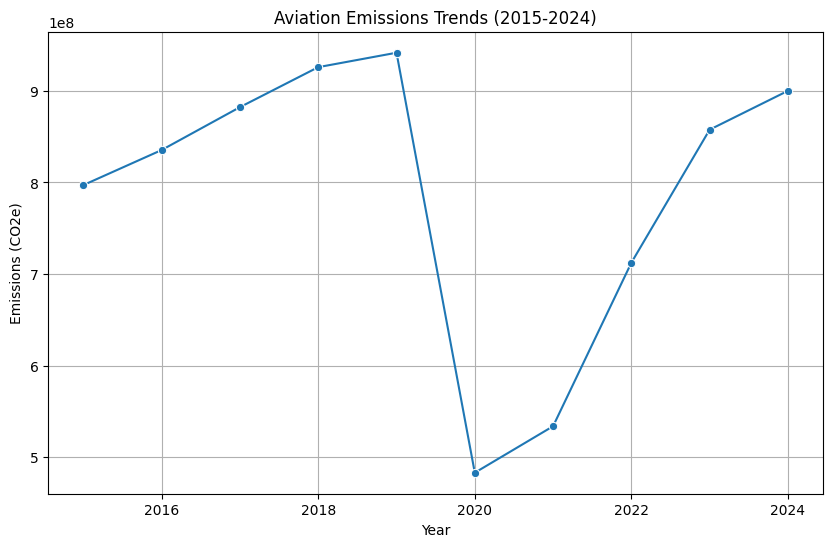

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=emissions_trend, x='year', y='emissions_quantity', marker='o')
plt.title('Aviation Emissions Trends (2015-2024)')
plt.xlabel('Year')
plt.ylabel('Emissions (CO2e)')
plt.grid(True)
plt.show()


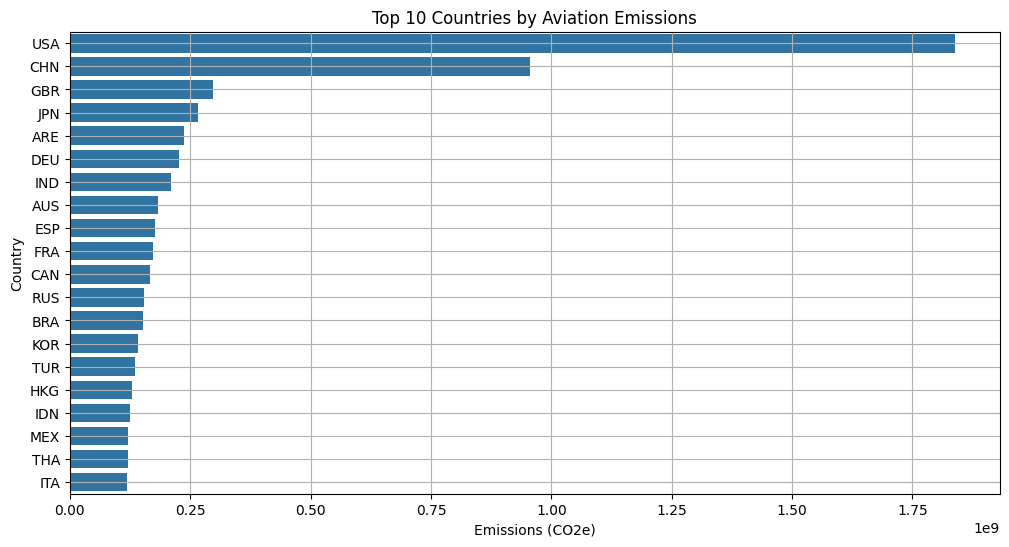

In [30]:
regional_emissions = aviation_country_merged.groupby('iso3_country')['emissions_quantity'].sum().sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=regional_emissions.values, y=regional_emissions.index)
plt.title('Top 10 Countries by Aviation Emissions')
plt.xlabel('Emissions (CO2e)')
plt.ylabel('Country')
plt.grid(True)
plt.show()

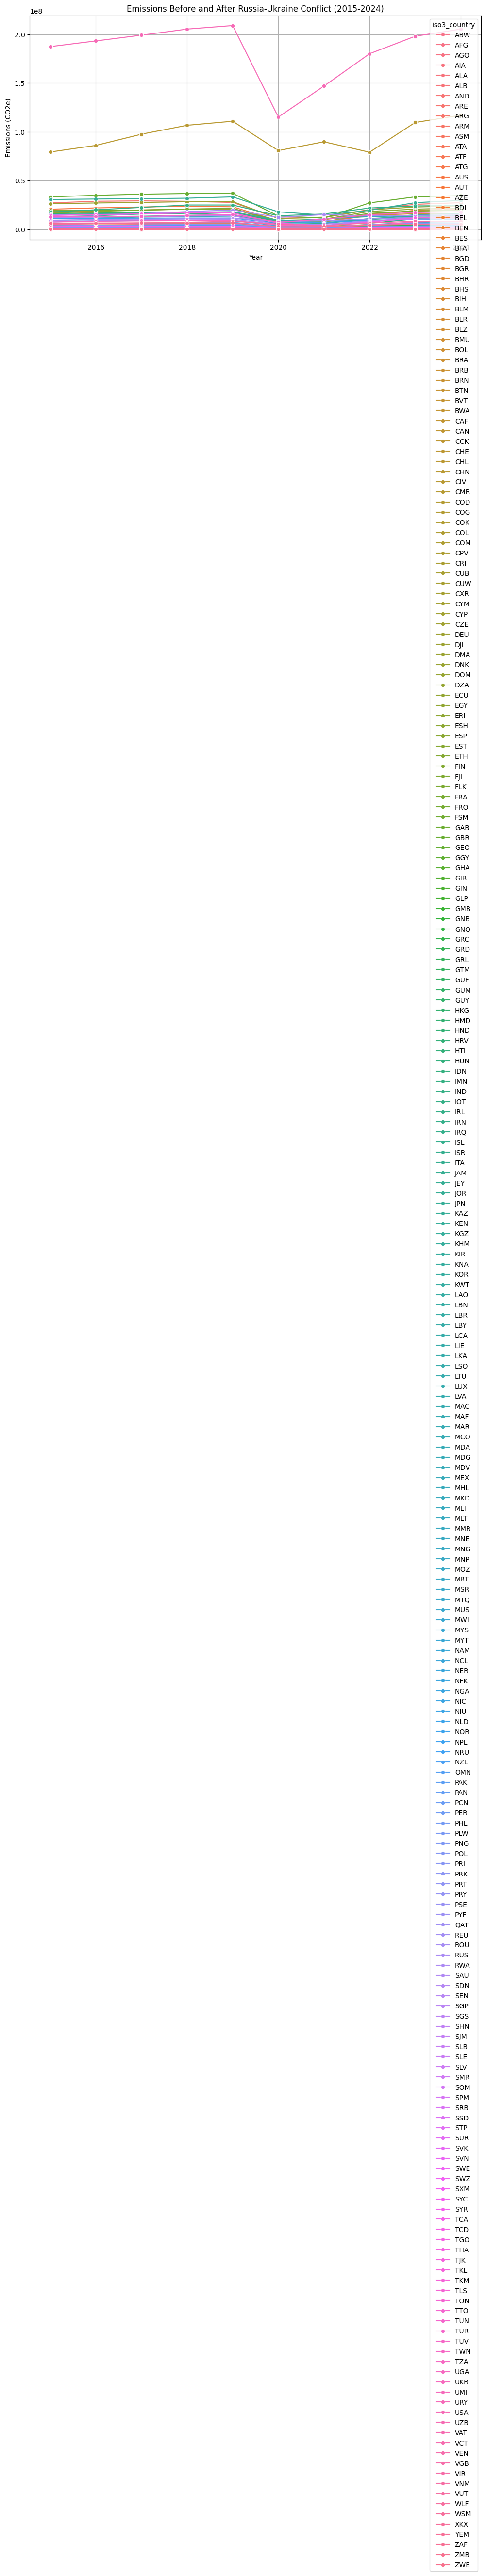

In [33]:
pre_conflict = aviation_country_merged[aviation_country_merged['year'] < 2022]
post_conflict = aviation_country_merged[aviation_country_merged['year'] >= 2022]
conflict_trend = aviation_country_merged.groupby(['year', 'iso3_country'])['emissions_quantity'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=conflict_trend, x='year', y='emissions_quantity', hue='iso3_country', marker='o')
plt.title('Emissions Before and After Russia-Ukraine Conflict (2015-2024)')
plt.xlabel('Year')
plt.ylabel('Emissions (CO2e)')
plt.grid(True)
plt.show()


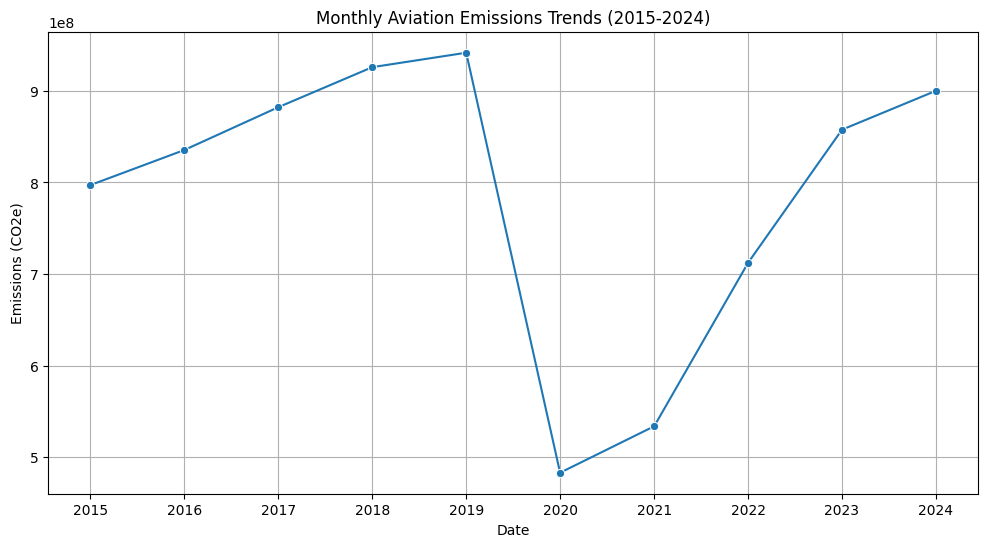

In [34]:
aviation_country_merged['month'] = pd.to_datetime(aviation_country_merged['start_time']).dt.month
monthly_trend = aviation_country_merged.groupby(['year', 'month'])['emissions_quantity'].sum().reset_index()
monthly_trend['date'] = pd.to_datetime(monthly_trend[['year', 'month']].assign(day=1))

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_trend, x='date', y='emissions_quantity', marker='o')
plt.title('Monthly Aviation Emissions Trends (2015-2024)')
plt.xlabel('Date')
plt.ylabel('Emissions (CO2e)')
plt.grid(True)
plt.show()


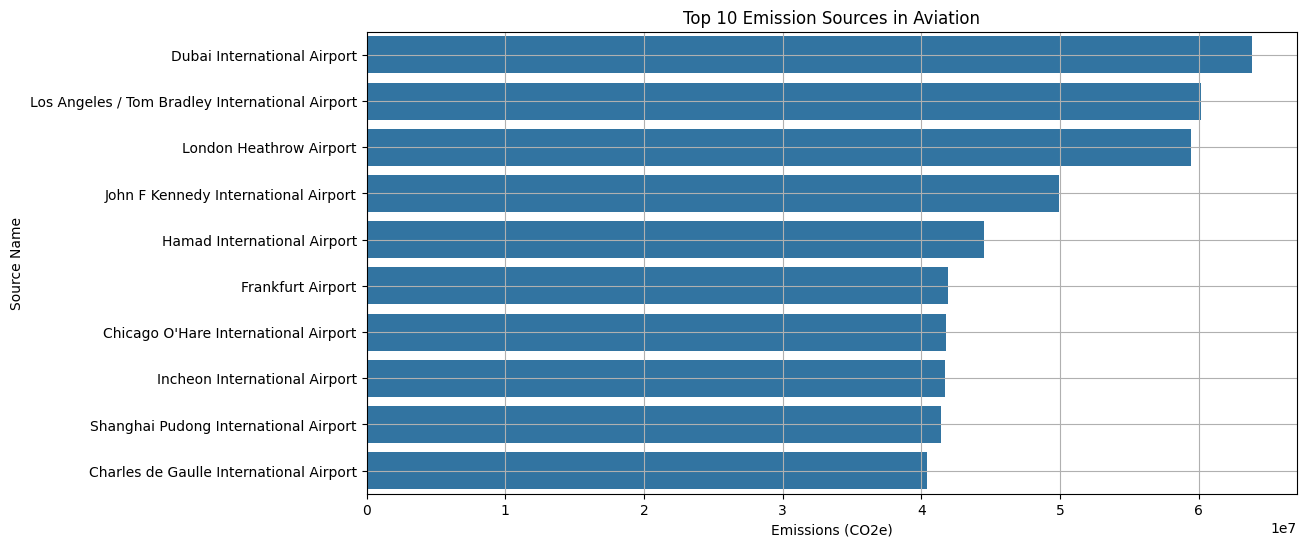

In [35]:
source_emissions = aviation_sources_merged.groupby('source_name')['emissions_quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=source_emissions.values, y=source_emissions.index)
plt.title('Top 10 Emission Sources in Aviation')
plt.xlabel('Emissions (CO2e)')
plt.ylabel('Source Name')
plt.grid(True)
plt.show()

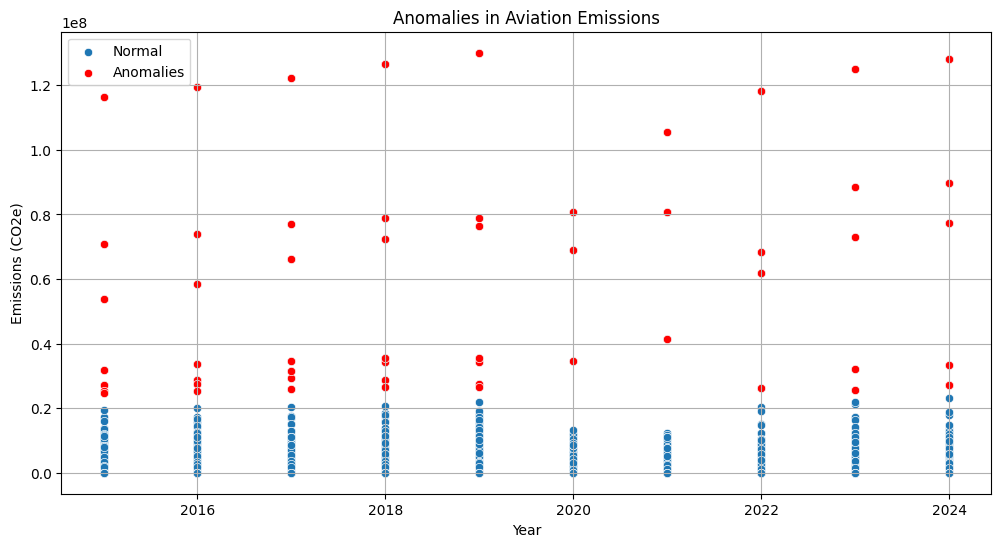

In [46]:
z_scores = (aviation_country_merged['emissions_quantity'] - aviation_country_merged['emissions_quantity'].mean()) / aviation_country_merged['emissions_quantity'].std()
anomalies = aviation_country_merged[z_scores > 3]

plt.figure(figsize=(12, 6))
sns.scatterplot(data=aviation_country_merged, x='year', y='emissions_quantity', label='Normal')
sns.scatterplot(data=anomalies, x='year', y='emissions_quantity', color='red', label='Anomalies')
plt.title('Anomalies in Aviation Emissions')
plt.xlabel('Year')
plt.ylabel('Emissions (CO2e)')
plt.legend()
plt.grid(True)
plt.show()

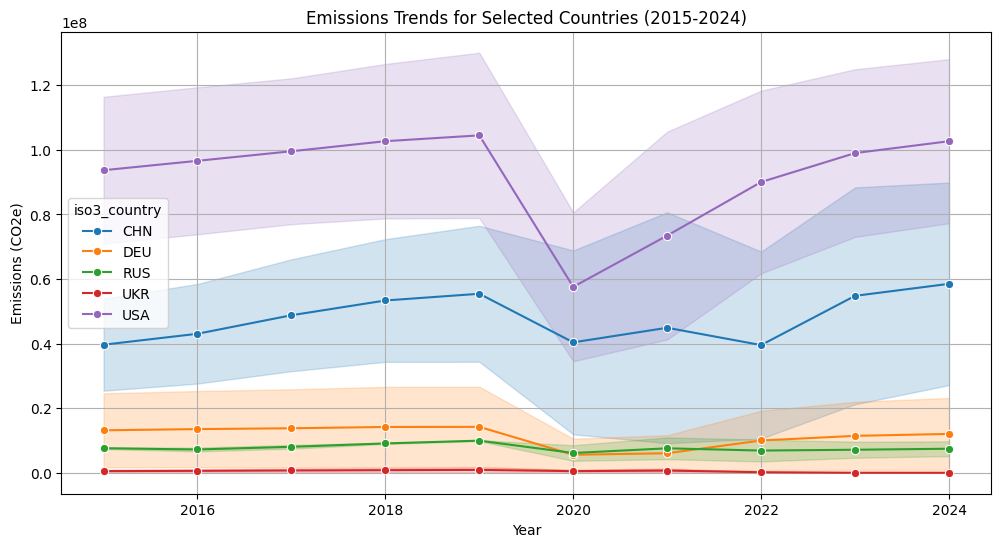

In [47]:
countries_to_plot = ['RUS', 'UKR', 'USA', 'CHN', 'DEU']
country_trends = aviation_country_merged[aviation_country_merged['iso3_country'].isin(countries_to_plot)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=country_trends, x='year', y='emissions_quantity', hue='iso3_country', marker='o')
plt.title('Emissions Trends for Selected Countries (2015-2024)')
plt.xlabel('Year')
plt.ylabel('Emissions (CO2e)')
plt.grid(True)
plt.show()


In [48]:
# Insight:
# This visualization compares emissions changes in Russia, Ukraine, and other key countries, highlighting shifts potentially caused by geopolitical events.

# NLP Integration for Text Analysis and Summaries
from transformers import pipeline

# Load summarization pipeline
summarizer = pipeline("summarization")

summary_input = """
Analyze the emissions trends and anomalies detected in aviation data for Russia and Ukraine, focusing on changes before and after 2022.
Highlight patterns related to geopolitical events and provide a narrative about disruptions and recoveries in emissions levels.
"""

summary_output = summarizer(summary_input, max_length=130, min_length=30, do_sample=False)
print("NLP Summary:", summary_output[0]['summary_text'])

# Insight:
# The NLP-generated summary helps contextualize findings by linking emissions patterns with geopolitical events, enabling clear communication in reports.

# NLP Enhancement: Sentiment Analysis
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis")

policy_texts = [
    "Russia imposed flight bans after geopolitical tensions escalated in 2022.",
    "Countries imposed strict regulations reducing aviation activity post-2020 pandemic.",
    "Efforts to restore aviation networks increased emissions in 2023."
]

sentiment_results = sentiment_pipeline(policy_texts)
for text, result in zip(policy_texts, sentiment_results):
    print(f"Text: {text}\nSentiment: {result['label']} (Confidence: {result['score']:.2f})\n")

# Insight:
# Sentiment analysis reveals how policy changes influenced aviation trends, identifying positive or negative tones in regulatory actions.


No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu
Your max_length is set to 130, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


NLP Summary:  Analyze emissions trends and anomalies detected in aviation data for Russia and Ukraine . Focus on changes before and after 2022 . Highlights patterns related to geopolitical events and provide a narrative about disruptions .


Device set to use cpu


Text: Russia imposed flight bans after geopolitical tensions escalated in 2022.
Sentiment: NEGATIVE (Confidence: 0.98)

Text: Countries imposed strict regulations reducing aviation activity post-2020 pandemic.
Sentiment: NEGATIVE (Confidence: 0.96)

Text: Efforts to restore aviation networks increased emissions in 2023.
Sentiment: POSITIVE (Confidence: 0.82)



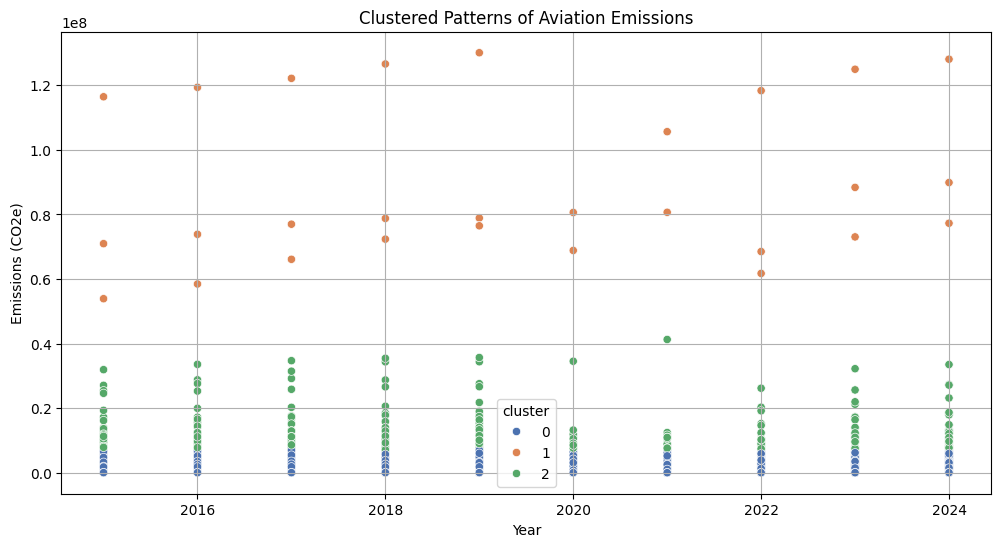

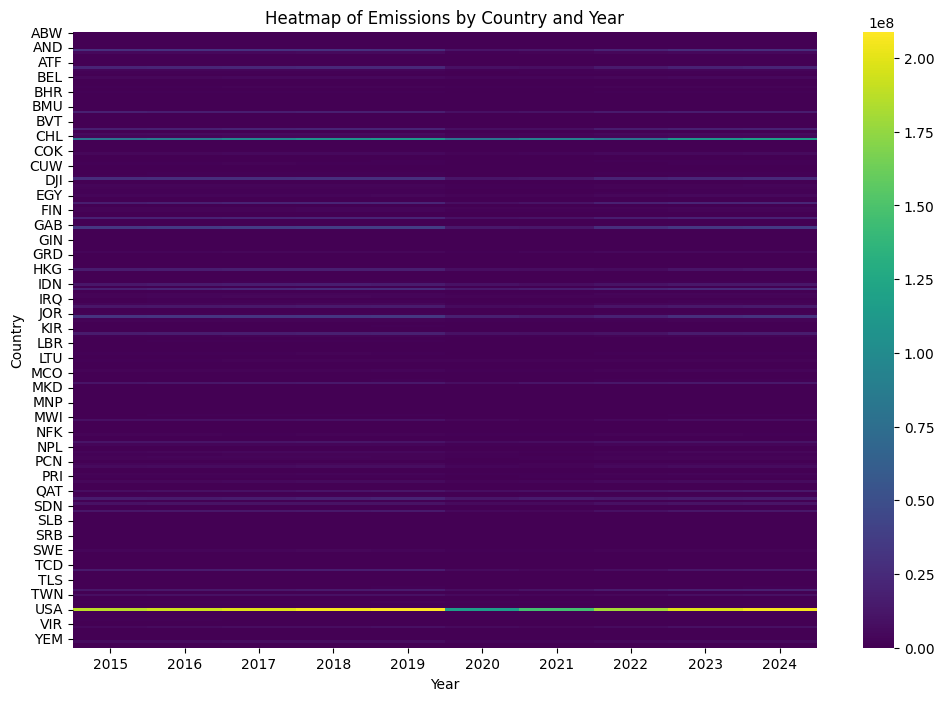

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(aviation_country_merged[['emissions_quantity']])

kmeans = KMeans(n_clusters=3, random_state=0).fit(scaled_features)
aviation_country_merged['cluster'] = kmeans.labels_

plt.figure(figsize=(12, 6))
sns.scatterplot(data=aviation_country_merged, x='year', y='emissions_quantity', hue='cluster', palette='deep')
plt.title('Clustered Patterns of Aviation Emissions')
plt.xlabel('Year')
plt.ylabel('Emissions (CO2e)')
plt.grid(True)
plt.show()

# Heatmap Representation
pivot_table = aviation_country_merged.pivot_table(index='iso3_country', columns='year', values='emissions_quantity', aggfunc='sum')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='viridis', annot=False)
plt.title('Heatmap of Emissions by Country and Year')
plt.xlabel('Year')
plt.ylabel('Country')
plt.show()

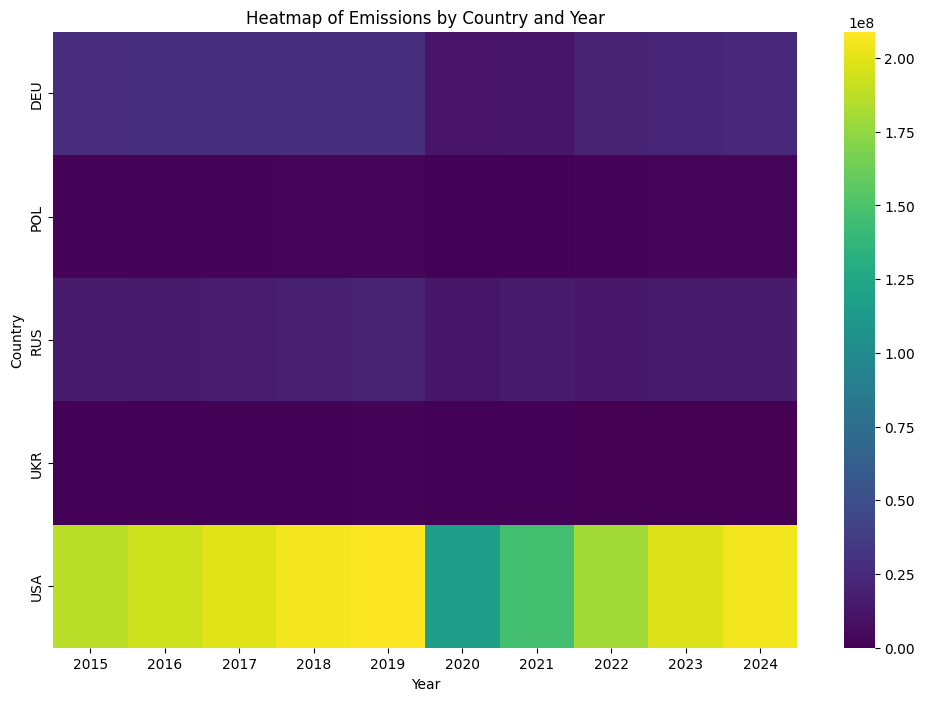

In [50]:
affected_countries = ['RUS', 'UKR', 'USA', 'DEU', 'POL']
heatmap_data = aviation_country_merged[aviation_country_merged['iso3_country'].isin(affected_countries)]
heatmap_pivot = heatmap_data.pivot_table(values='emissions_quantity', index='iso3_country', columns='year', aggfunc='sum')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_pivot, cmap='viridis', annot=False)
plt.title('Heatmap of Emissions by Country and Year')
plt.xlabel('Year')
plt.ylabel('Country')
plt.show()


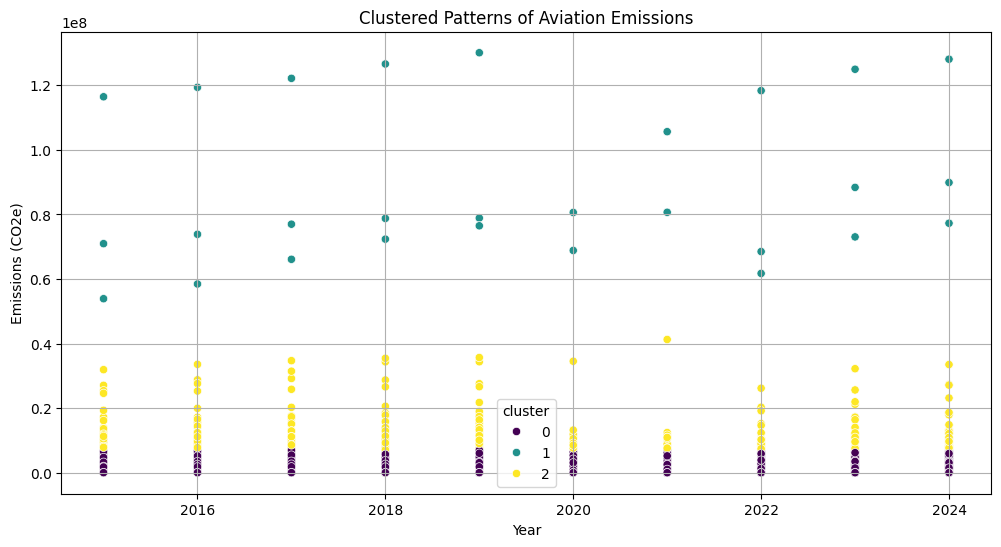

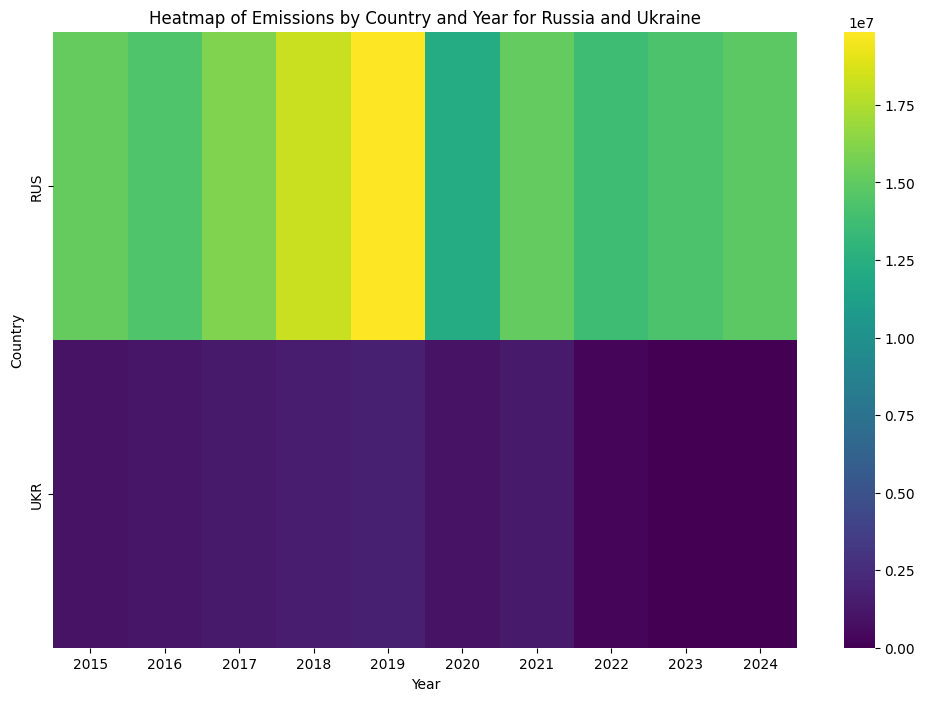

In [51]:
scaler = StandardScaler()
emissions_scaled = scaler.fit_transform(aviation_country_merged[['emissions_quantity']])

kmeans = KMeans(n_clusters=3, random_state=0).fit(emissions_scaled)
aviation_country_merged['cluster'] = kmeans.labels_

plt.figure(figsize=(12, 6))
sns.scatterplot(data=aviation_country_merged, x='year', y='emissions_quantity', hue='cluster', palette='viridis')
plt.title('Clustered Patterns of Aviation Emissions')
plt.xlabel('Year')
plt.ylabel('Emissions (CO2e)')
plt.grid(True)
plt.show()

# Heatmaps for Affected Countries
affected_countries = ['RUS', 'UKR']
heatmap_data = aviation_country_merged[aviation_country_merged['iso3_country'].isin(affected_countries)]
heatmap_pivot = heatmap_data.pivot_table(values='emissions_quantity', index='iso3_country', columns='year', aggfunc='sum')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_pivot, cmap='viridis', annot=False)
plt.title('Heatmap of Emissions by Country and Year for Russia and Ukraine')
plt.xlabel('Year')
plt.ylabel('Country')
plt.show()

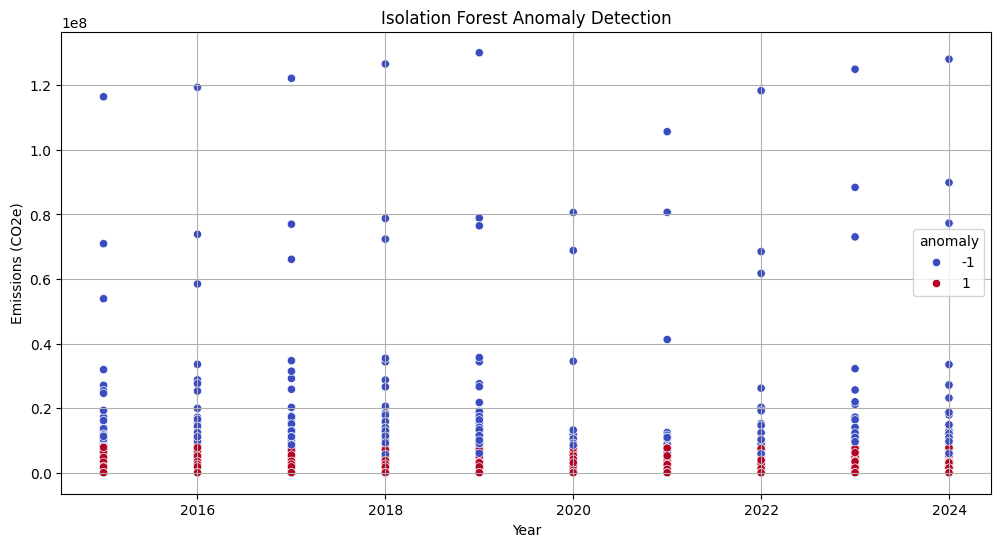

In [54]:
iso_forest = IsolationForest(contamination=0.05, random_state=0)
aviation_country_merged['anomaly'] = iso_forest.fit_predict(aviation_country_merged[['emissions_quantity']])

plt.figure(figsize=(12, 6))
sns.scatterplot(data=aviation_country_merged, x='year', y='emissions_quantity', hue='anomaly', palette='coolwarm')
plt.title('Isolation Forest Anomaly Detection')
plt.xlabel('Year')
plt.ylabel('Emissions (CO2e)')
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


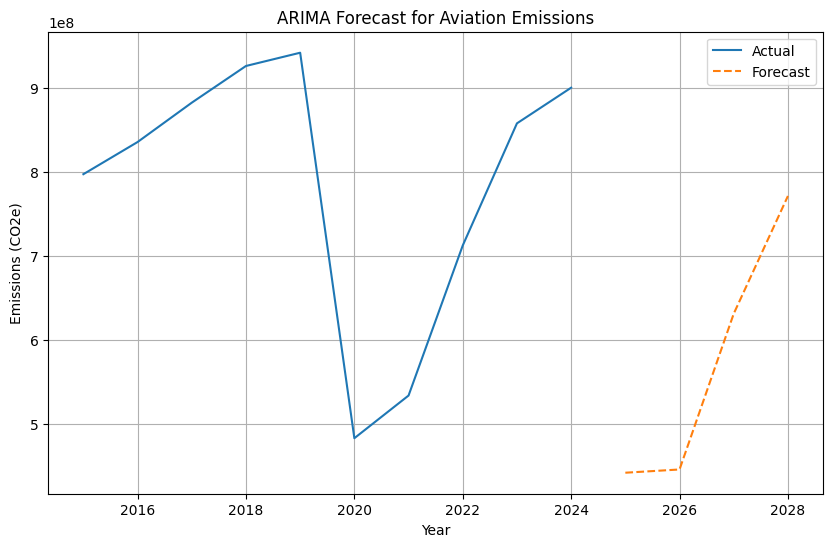

In [56]:
aviation_country_merged['year'] = pd.to_datetime(aviation_country_merged['start_time']).dt.year
emissions_trend = aviation_country_merged.groupby('year')['emissions_quantity'].sum().reset_index()

model = ARIMA(emissions_trend['emissions_quantity'], order=(5, 1, 0))
results = model.fit()
forecast = results.forecast(steps=4)

plt.figure(figsize=(10, 6))
plt.plot(emissions_trend['year'], emissions_trend['emissions_quantity'], label='Actual')
plt.plot(range(emissions_trend['year'].max() + 1, emissions_trend['year'].max() + 5), forecast, label='Forecast', linestyle='--')
plt.title('ARIMA Forecast for Aviation Emissions')
plt.xlabel('Year')
plt.ylabel('Emissions (CO2e)')
plt.legend()
plt.grid(True)
plt.show()


In [57]:
geo_df = gpd.GeoDataFrame(aviation_sources_merged, geometry=gpd.points_from_xy(aviation_sources_merged.lon, aviation_sources_merged.lat))

m = folium.Map(location=[0, 0], zoom_start=2)
for idx, row in geo_df.iterrows():
    folium.CircleMarker(location=[row['geometry'].y, row['geometry'].x], radius=5, color='blue', fill=True).add_to(m)
m.save('aviation_map.html')


KeyboardInterrupt: 

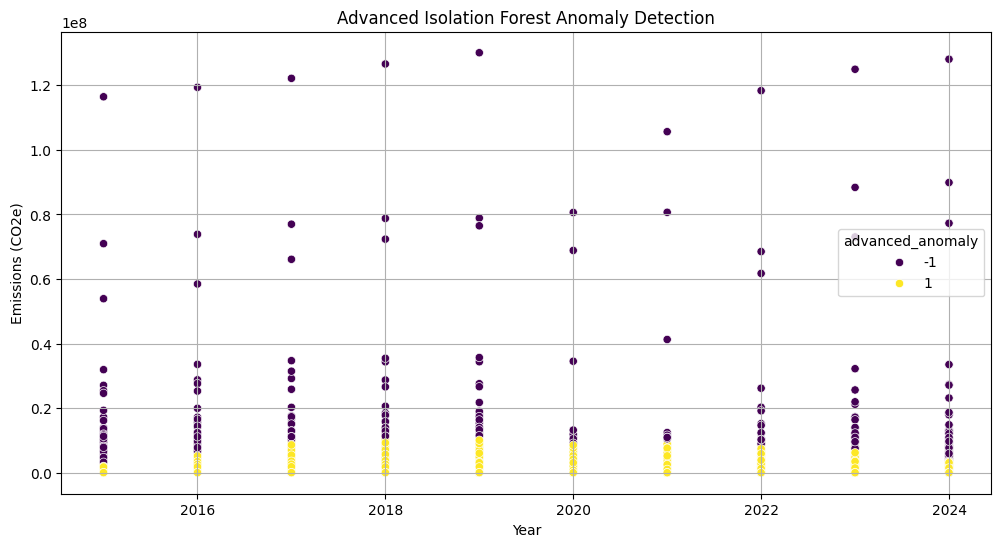

In [58]:
features = ['emissions_quantity', 'year']
scaled_data = StandardScaler().fit_transform(aviation_country_merged[features])
iso_forest_advanced = IsolationForest(contamination=0.05, random_state=42)
aviation_country_merged['advanced_anomaly'] = iso_forest_advanced.fit_predict(scaled_data)

plt.figure(figsize=(12, 6))
sns.scatterplot(data=aviation_country_merged, x='year', y='emissions_quantity', hue='advanced_anomaly', palette='viridis')
plt.title('Advanced Isolation Forest Anomaly Detection')
plt.xlabel('Year')
plt.ylabel('Emissions (CO2e)')
plt.grid(True)
plt.show()


In [59]:
grouped = aviation_country_merged.groupby(['iso3_country', 'year'])['emissions_quantity'].sum().reset_index()


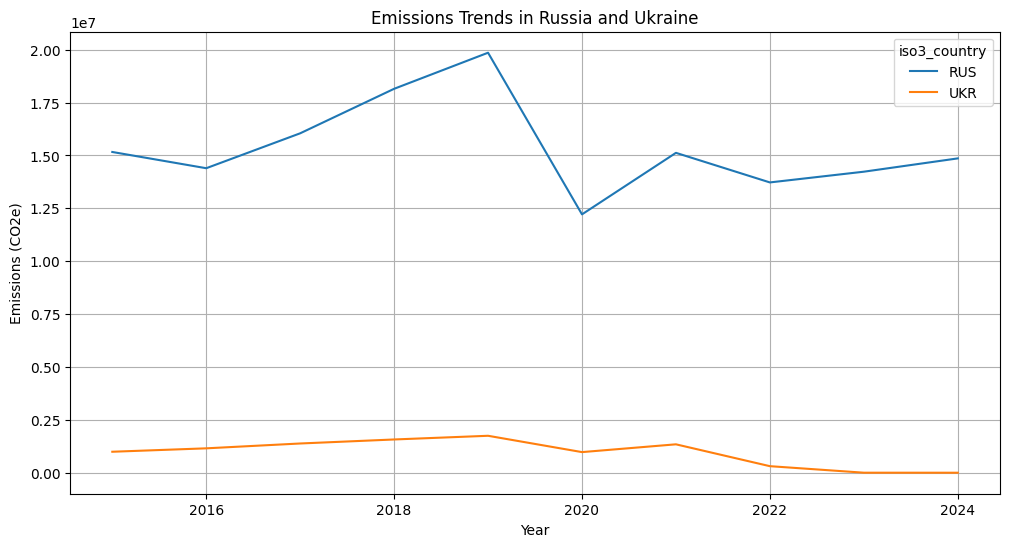

In [60]:
selected_countries = grouped[grouped['iso3_country'].isin(['RUS', 'UKR'])]
plt.figure(figsize=(12, 6))
sns.lineplot(data=selected_countries, x='year', y='emissions_quantity', hue='iso3_country')
plt.title('Emissions Trends in Russia and Ukraine')
plt.xlabel('Year')
plt.ylabel('Emissions (CO2e)')
plt.grid(True)
plt.show()

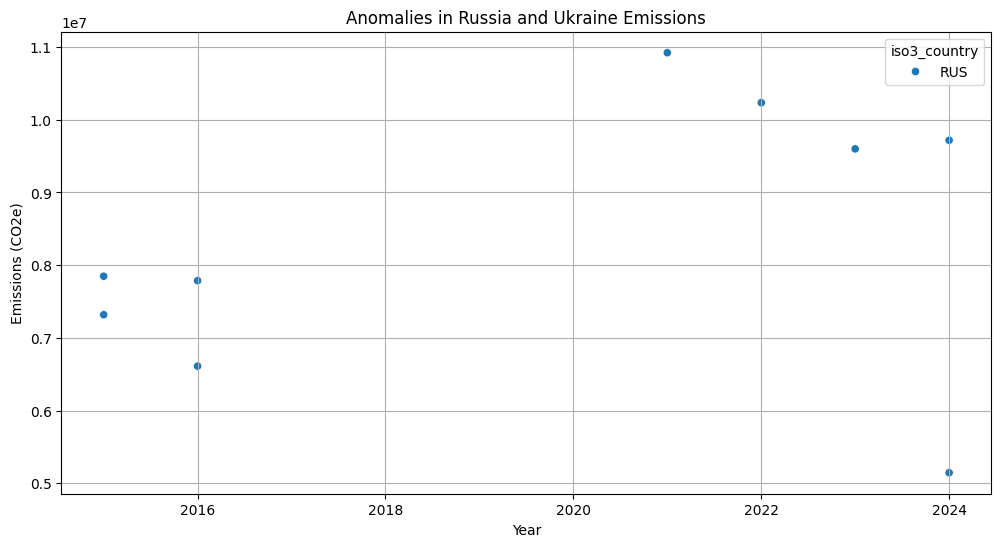

In [61]:
selected_anomalies = aviation_country_merged[(aviation_country_merged['iso3_country'].isin(['RUS', 'UKR'])) & (aviation_country_merged['advanced_anomaly'] == -1)]
plt.figure(figsize=(12, 6))
sns.scatterplot(data=selected_anomalies, x='year', y='emissions_quantity', hue='iso3_country')
plt.title('Anomalies in Russia and Ukraine Emissions')
plt.xlabel('Year')
plt.ylabel('Emissions (CO2e)')
plt.grid(True)
plt.show()

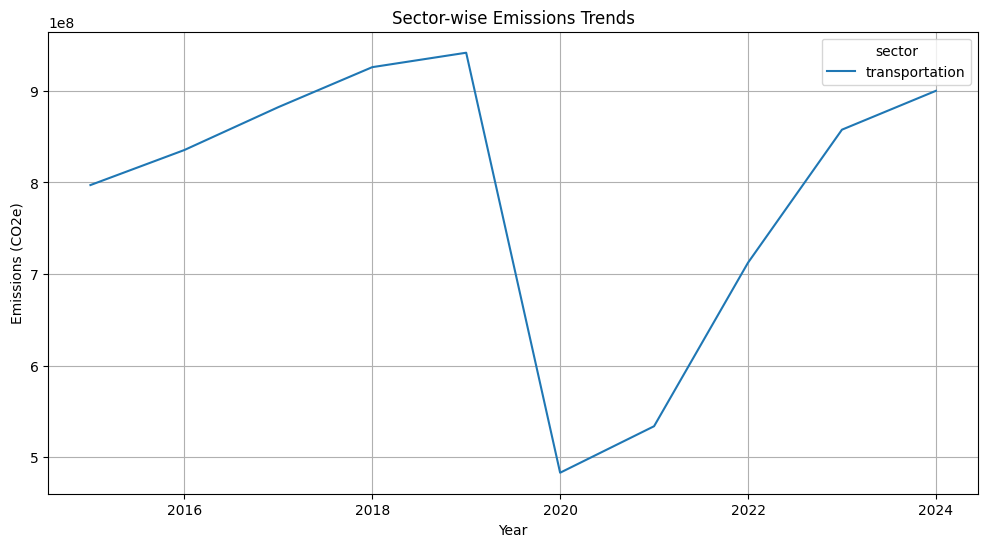

In [66]:
sector_trends = aviation_country_merged.groupby(['sector', 'year'])['emissions_quantity'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=sector_trends, x='year', y='emissions_quantity', hue='sector')
plt.title('Sector-wise Emissions Trends')
plt.xlabel('Year')
plt.ylabel('Emissions (CO2e)')
plt.grid(True)
plt.show()